# Node2vec for network analysis

One of the hottest topic of research in deep learning is graph neural networks. The last few years saw the number of publications regarding graph neural networks grow in some of the major conferences such as ICLR and NeurIPS. One of the first models to use neural networks and show a considerable improvement on the tasks of node classification and link prediction is *Node2vec*. The [paper](https://arxiv.org/abs/1607.00653), by researchers at Stanford University, took advantage of advances made in the nlp field to process graph data as a series of nodes generating embeddings of the nodes for use in downstream tasks. The authors avoid some of the difficulties in processing network data by creating random walks the nodes in the graph and using the information about the sequence of nodes traversed as the input data for the embedding algorithm, in this case the *skipgram* model of *word2vec*. This directly addressed one of the complexities of working with graph data the irregularity of the data structures. While images can be represented as are grids of pixels and text can be represented as sequences of symbols, it is not as simple when it comes to graphs. Graphs do not have fixed node ordering or reference point, there is also a wide variation in the structure of the graphs e.g. one node can be connected to 100 nodes while another one may only have one connection. The authors also point to the limitations of more traditional techniques such as dimensionality reduction since they scale poorly to large networks and the resulting representations perform poorly in downstream tasks. See this really great explanation on why *node2vec* excels where previous models failed by [Jure Leskovec](http://web.stanford.edu/class/cs224w/slides/07-noderepr.pdf) one of the authors of the original paper and a lead researcher on the field. 

Besides the idea of using embeddings to represent the data the model introduces *biased random walks*. The biased random walks and its parameters *p* and *q* allow the random walk to implement different exploration strategies. This [post](https://towardsdatascience.com/node2vec-graph-embedding-method-f306ac87004e) provides a good explanation of the biased random walks and how the distance from the original node and the nodes in the neighborhood of the subsequent node are affected by the *p* and *q* parameter. The return parameter *p* controls the likelihood of inmediately traveling back to a node recently traversed, and as such it can favor a breadth first search (BFS) where we explore local neighborhoods and find embeddings that better capture structural equivalence. The in-out parameter *q* controls the likelihood of walking away from the previous node and as such can favor a depth first search (DFS) which in turn produces embeddings that better capture homophily. To put it simply the authors generate random walks for each node to serve as sentences, and then use those sentences as a input for a shallow embedding model. After those embeddings are obtained they are used in downstream tasks, primarily node and link prediction.

The dataset that I will use to test the model is the bike trip data from [Capitol Bike Share](https://s3.amazonaws.com/capitalbikeshare-data/index.html). The data comprises several million trips made between 2010 and 2020. I processed every trip as an adjacency list where the weights correspond to the number of trips made between each pair of nodes. The script to create the data can be found [here](https://github.com/jlealtru/website_tutorials/blob/main/notebooks/%20processing_capital_bikeshare_data.ipynb). To implement the node2vec algorithm I am using the library [stellargraph] (https://github.com/stellargraph/stellargraph), a graph machine learning library written in Python developed by Australia's national science agency. This library contains many graph neural networks models as well as some datasets and demos. I will be using the node2vec implementation that uses gensim as the engine to produce the embeddings with the skip gram algorithm; they also provide a Keras implementation for the word embeddings section.

As mentioned in the node2vec paper the authors evaluated the performance of the model on node and link prediction tasks for different datasets. For this task the nodes in the data do not have a natural label to evaluate the performance of the model in a downstream task. So I will limit my analysis to generate embeddings and clustering as demonstrated in the paper with the *Les Miserables* data. Specifically I would like to cluster bike stations based on the role they play in the network (e.g. does a particular station serves as a hub or not).

In [1]:
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
import os
import zipfile
import numpy as np
import matplotlib as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import igraph as ig
%matplotlib inline

The first step in the analysis consists on preparing the data to be analyzed in a format that stellargraph can recognize. The library can import an edge list from a dataframe as long as the columns are specified in the right format with the edge pairs named 'source' and 'target' and any additional attribute for the edges after. In this case I saved the data in the appropiate format so importing it into stellargraph is trivial. I simply load the csv file as a dataframe and initialize a weighted directed graph.

It is also worth nothing that while other versions of node2vec exists the stellargraph library makes the implementation of biased random walks for directed weighted networks possible.

In [2]:
# read csv data
graph_data = pd.read_csv('../data/capital_bikes/graph_data_full.csv')

In [3]:
# instantiate a directed graph with our edge list
graph_bikes = sg.StellarDiGraph(edges = graph_data)

In [4]:
# check that the attributes are correctly loaded
graph_bikes.info()

'StellarDiGraph: Directed multigraph\n Nodes: 708, Edges: 150527\n\n Node types:\n  default: [708]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [150527]\n        Weights: range=[1, 42863], mean=175.382, std=688.561\n        Features: none'

The resulting graph has 708 different nodes (some of the stations in the data no longer exists but I decided to include them in the analysis to get a more complete view of the network) and 150 thousand plus edges. For this graph the weights represent the number of trips between each station so we are in the presence of a directed weighted graph. Node2vec can manage both directed and undirected as well as weighted graphs so there is no need to conduct any additional modifications.

The next step in the analysis, and the critical part of it, is to define a list of random walks so we can use this list of *sentences* as the input for the word2vec algorithm. As mentioned in the introduction the main decision we can make revolves around how much do we want to favor the creation of embbeddings that capture homophily (communities) versus embeddings that capture the structural roles that the nodes play in the graph. Since I was interested in identifying bike stations that serve as hubs, meaning stations that serve links to other modes of transportation I decided to encourage exploration of nodes in a breadh first fashion to capture structural similarities. I use the parameters defined in the paper such as length of the random walk set to 80, number of random walks per root node to 10, a return value *p* of 0.25 to foster local exploration and an out parameter *q* with a value of 1. 

For the word2vec model I use 128 dimensions for the resulting embedding, a window size of 10, 20 epochs of training and the default parameters of the gensim word2vect implementation.

In [5]:
rw = BiasedRandomWalk(graph_bikes, p = 0.25, q = 1, n = 10, length = 80, 
                      seed=42, weighted = True)

In [6]:
walks = rw.run(nodes=list(graph_bikes.nodes())
               # root nodes
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 7080


In [7]:
# we pass the random walks to a list
str_walks = [[str(n) for n in walk] for walk in walks]

After the random walks have been generated we parse them into lists of lists. This is an easy way to feed the data to word2vec to generate the embeddings. Since we have 708 nodes and we conducted 10 random walks per node we will have 7,080 walks to feed into the model; these walks are anologous to sentences in the word2vec world. 

In [8]:
# run the model for 20 epochs with a window size of 10.
model = Word2Vec(str_walks, size=128, window=10, min_count=1, sg=1, workers=4, iter=20)

After the model has run we use some of the same tools available with Gemsim and find the most similar 'nodes' in our network when compared to each other as measured by cosine distance. For example let's see what are the most similar stations to the bike station on the Convention Center in Downtown DC. This station is located in a central part of town, next to a metro station, and in an area with lots of foot traffic. The most similar stations are almost all in downtown DC and many of them have a metro station right next to it. But to really understand if we are capturing homopholy or structural roles I am going to cluster all the embeddings of our nodes and see if the location of those embeddings reveal something about the structure of the data.


In [9]:
# check for the most similar station in the embeddings space
model.wv.most_similar('Convention Center / 7th & M St NW')

[('8th & O St NW', 0.6857138872146606),
 ('11th & M St NW', 0.6807775497436523),
 ('Metro Center / 12th & G St NW', 0.6762484312057495),
 ('Largo Town Center Metro', 0.6759693622589111),
 ('8th & H St NW', 0.6740933656692505),
 ('1301 McCormick Dr / Wayne K. Curry Admin Bldg', 0.667463481426239),
 ('Thomas Circle', 0.6615563631057739),
 ('15th & K St NW', 0.6581323146820068),
 ('10th & K St NW', 0.6560524702072144),
 ('7th & F St NW / National Portrait Gallery', 0.6523153781890869)]

In [10]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (model.wv.vectors) 

We will use  *k-means*, the work horse of clustering algorithms and also the algorithm implemented in the node2vec paper, as well as *HDBSCAN* to identify clusters of nodes. For k-means we have to rely on the elbow method to identify the optimal number of algorithms. HBSCAN actually does not require that we set the number of clusters in advance. HDBSCAN uses a density-based approach that looks for regions of the data that are denser than the surrounding space and defines clusters based on this. The algorithm creates a circle around each point in the data based on the parameter `min_samples` till it emcompasses the number of points defined by this paramether, in practice this parameter is set to the same value as `min_cluster_size`. The circle will have a radius equal to the longest distance to the fartest point in the neighborhood with the points defined in the previous step; this is known as *core distance*. 
image

source: 

The algorithm then evaluates how easy it is to get from one circle to other circle this is known as *mutual reachability distance*. The algorithm then uses an implementation of minimum spanning tree to build the hierarchy of clusters. Finally hdbscan walks through the tree and at each split checks if the new cluster created by the split has fewer points than the minimum cluster size, if this is true then drops those points as noise and keep the points in the parent cluster. If the split has the minimun size of points define the algorithm considers the split valid and have new clusters. The algorithm stops once the entire tree has been traversed. The [documentation](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) of the pyhton library explains this process quite well. Also this [post](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)goes more in depth on how the algorithm works.

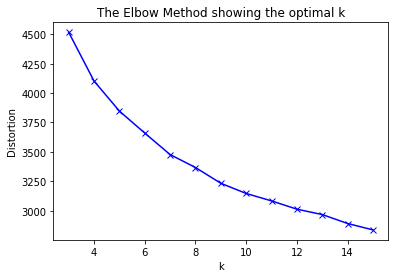

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
K = range(3,16)
for k in K:
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(node_embeddings)
    k_cluster.fit(node_embeddings)
    distortions.append(k_cluster.inertia_)
    #distortions.append(sum(np.min(cdist(node_embeddings, k_cluster.cluster_centers_, 
    #                                    'euclidean'), axis=1)) / node_embeddings.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method suggest the optimal number of clusters is somethere probably around 10.

For HDBSCAN we will select as the minimum cluster size as 5.

In [12]:
# get clustering for 8 labels
kmeans_cluster = KMeans(n_clusters=10, 
                        init='k-means++', n_init=300, random_state=3425).fit(node_embeddings)
kmeans_labels = kmeans_cluster.labels_

In [32]:
# run the HDBSCAN cluster
import hdbscan
hdbs_model = hdbscan.HDBSCAN(min_cluster_size = 5)
hdbs_model.fit(node_embeddings)
hbds_scan_labels = hdbs_model.labels_

In [33]:
# create a dataframe of the nodes with their cluster labels
nodes_labels = pd.DataFrame(zip(node_ids, kmeans_labels, hbds_scan_labels), 
                            columns = ['node_ids','kmeans','hdbscan'])

Now that we have our results lets explore the results of the embedding using t-distributed stochastic neighbor embedding (t-SNE). The algorithm converts the high-dimensional euclidean distances between datapoints into conditional probabilities trying to preserve close points together under a Gaussian. The algorithm maximizes the the probability density of a pair of a points where nearby data points will have a high proability while farther points will be separated. Once this is identified t-sne tries to represent the data in a lower dimensionality (usually 2 or 3 dimensions) using gradient descent. Finally the algorithm uses a t distribution to compute the similarity between two points in the low-dimensional space. This [post](https://towardsdatascience.com/t-distributed-stochastic-neighbor-embedding-t-sne-bb60ff109561) summarizes the algorithm in more detail. This technique proposed in a [paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) by van der Maaten and Hinton (yes the same Hinton that played a key role in deep learning) has become a very common algorith to represent high dimensional data in a 2 dimensional space.

The algorithm is easy to implement but does require tinkering to obtain the desired results, specially with the `perplexity` and  `early_exaggeration` parameters. The values shown below are the ones that worked better for me.

In [34]:
# fit our embeddings with t-SNE
from sklearn.manifold import TSNE
trans = TSNE(n_components = 2, early_exaggeration = 10,
                  perplexity = 35, n_iter = 1000, n_iter_without_progress = 500,
                  learning_rate = 600.0, random_state = 42)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [35]:
# create the dataframe that has information about the nodes and their x and y coordinates
data_tsne = pd.DataFrame(zip(node_ids, list(node_embeddings_2d[:,0]),list(node_embeddings_2d[:,1])),
                        columns = ['node_ids','x','y'])
data_tsne = pd.merge(data_tsne, nodes_labels, left_on='node_ids', right_on='node_ids',
                how = 'left')

<function matplotlib.pyplot.show(close=None, block=None)>

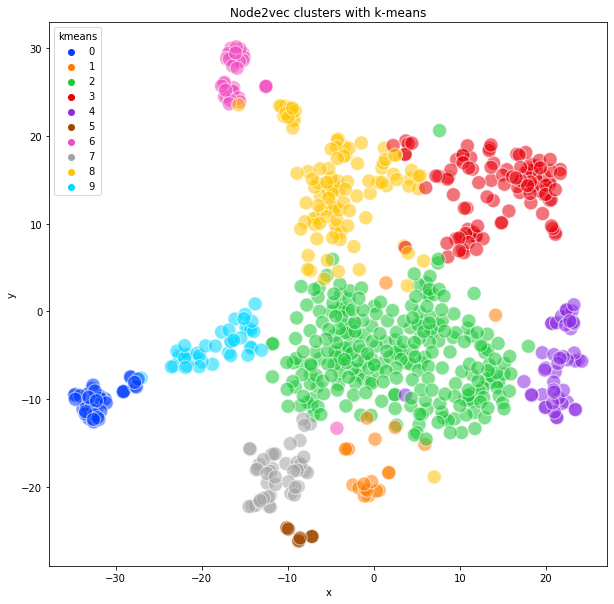

In [36]:
# plot using seaborn.
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_tsne, x='x', y='y',hue='kmeans', palette="bright",
               alpha=0.55, s=200).set_title('Node2vec clusters with k-means')
plt.savefig('images/kmeans_node2vec.svg')
plt.show

We can see that kmeans did a decent job at capturing the structure of the clusters and they are clearly separated with a few overlaps. Now lets see how the HBSCAN clusters look. 

<function matplotlib.pyplot.show(close=None, block=None)>

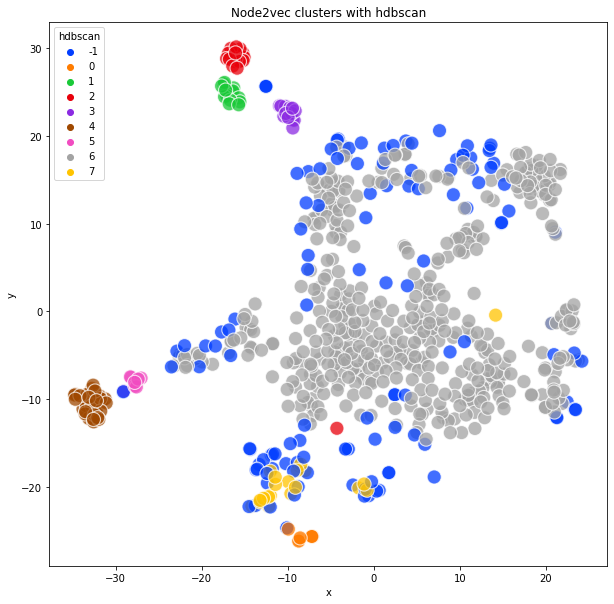

In [37]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_tsne, x='x', y='y',hue='hdbscan', palette="bright",
               alpha=0.75, s=200).set_title('Node2vec clusters with hdbscan')
plt.savefig('images/hdbscan_node2vec.svg')
plt.show

We can see that TSNE in tandem with a simple kmean cluster does a good job at creating separable clusters. There is overlap between both techniques with a large central clusyer identified by both techniques. 


In [38]:
import plotly.express as px

stations = pd.read_csv('../data/capital_bikes/bike_locations.csv')
stations = pd.merge(stations, nodes_labels, left_on='ADDRESS', right_on='node_ids',
                how = 'inner')
stations['kmeans'] = stations['kmeans'].astype(str)
stations['size'] = 5 
fig = px.scatter_mapbox(stations, lat="LATITUDE", lon="LONGITUDE", hover_name="node_ids", 
                        hover_data=['node_ids'],
                        size = 'size',
                        size_max = 10,
                        zoom=10, 
                        width=700, height=600, 
                        color_discrete_sequence=px.colors.qualitative.Plotly,
                        color = 'kmeans',
                       )
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

discussion of the neighborhoods and how this resembles homophily.

Lets check hdbscan

In [39]:
import plotly.express as px

stations = pd.read_csv('../data/capital_bikes/bike_locations.csv')
stations = pd.merge(stations, nodes_labels, left_on='ADDRESS', right_on='node_ids',
                how = 'inner')
stations['hdbscan'] = stations['hdbscan'].astype(str)
stations['size'] = 5 
fig = px.scatter_mapbox(stations, lat="LATITUDE", lon="LONGITUDE", hover_name="node_ids", 
                        hover_data=['node_ids'],
                        size = 'size',
                        size_max = 10,
                        zoom=10, 
                        width=700, height=600, 
                        color_discrete_sequence=px.colors.qualitative.Plotly,
                        color = 'hdbscan',
                       )
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Since we do not have ground truth labels of the nodes from the embeddings, lets get some summary statistics of the clusters and see how intuitive the results are based on these summary statistics. 

One of the drabacks of the node2vec and the deepwalk algorithms is that the results you obtain from these algorithms is shaped by structural characteristics. [Researchers from Hannover University and University of Stavanger](https://arxiv.org/abs/1903.07902) showed that for directed graphs with low clustering, low transitivity and low reciprocity the biased random walks wouldn't offer additional information that can be used during the creation of the embeddings. For this part of the analysis I will use the python implementation of igraph a popular network analysis library. I am interested in understanding if the embeddings are able to effectively capture structural similarities between nodes.

In [23]:
# check the structural characteristics of the graph
import networkx as nx
graph_bikes_nx = nx.from_pandas_edgelist(graph_data, 'source', 'target', ['weight'], create_using=nx.DiGraph)
graph_bikes_clustering_coefficient  = nx.average_clustering(graph_bikes_nx, weight='weight')
graph_bikes_transitivity_coefficient = nx.transitivity(graph_bikes_nx)
graph_bikes_reciprocity  = nx.reciprocity(graph_bikes_nx)
graph_bike_properties = {'clustering coefficient':graph_bikes_clustering_coefficient, 
                    'transitivity_coefficient': graph_bikes_transitivity_coefficient, 
                    'reciprocity': graph_bikes_reciprocity}
print(graph_bike_properties)

{'clustering coefficient': 0.0009101886691383708, 'transitivity_coefficient': 0.6945816318976256, 'reciprocity': 0.840115062414052}


discussion on why the graph seems to have failed at capturing structural equalities but capture local homophily quite well. low clustering coefficient.

## Conclussion
